In [35]:
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam

In [36]:
import matplotlib.pyplot as plt

In [37]:
import sys

In [38]:
import numpy as np

In [39]:
class GAN():
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channels = 1
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    def build_generator(self):
        model = Sequential()
        model.add(Dense(256, input_dim=self.latent_dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh')) # activation='tanh'なので-1,1の範囲の値を持つ。
        model.add(Reshape(self.img_shape))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_discriminator(self):
        model = Sequential()
        model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
        (X_train, _), (_, _) = mnist.load_data()

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random batch of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Generate a batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)
                
    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/%d.png" % epoch)
        plt.close()

In [40]:
gan = GAN()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________
____

In [7]:
gan.train(epochs=30000, batch_size=32, sample_interval=200)

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.605774, acc.: 57.81%] [G loss: 0.750486]
1 [D loss: 0.418830, acc.: 67.19%] [G loss: 0.836757]
2 [D loss: 0.277435, acc.: 89.06%] [G loss: 0.968017]
3 [D loss: 0.237102, acc.: 96.88%] [G loss: 1.130571]
4 [D loss: 0.211644, acc.: 95.31%] [G loss: 1.303356]
5 [D loss: 0.183867, acc.: 100.00%] [G loss: 1.465740]
6 [D loss: 0.166816, acc.: 98.44%] [G loss: 1.630031]
7 [D loss: 0.127560, acc.: 98.44%] [G loss: 1.754423]
8 [D loss: 0.109001, acc.: 100.00%] [G loss: 1.855841]
9 [D loss: 0.095926, acc.: 100.00%] [G loss: 1.949454]
10 [D loss: 0.084305, acc.: 100.00%] [G loss: 2.040939]
11 [D loss: 0.081627, acc.: 100.00%] [G loss: 2.159201]
12 [D loss: 0.079605, acc.: 100.00%] [G loss: 2.186829]
13 [D loss: 0.072586, acc.: 100.00%] [G loss: 2.248205]
14 [D loss: 0.066181, acc.: 100.00%] [G loss: 2.306821]
15 [D loss: 0.063954, acc.: 100.00%] [G loss: 2.421555]
16 [D loss: 0.061489, acc.: 100.00%] [G loss: 2.560567]
17 [D loss: 0.052106, acc.: 100.00%] [G loss: 2.541336]
18 [D los

In [20]:
gan.generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         1493520   
Total params: 1,493,520
Trainable params: 1,489,936
Non-trainable params: 3,584
_________________________________________________________________


In [22]:
gan.discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 533505    
Total params: 1,067,010
Trainable params: 533,505
Non-trainable params: 533,505
_________________________________________________________________


In [23]:
# gan.generator.save('/saved_model/gan_generator.h5')
# gan.discriminator.save('/saved_model/gan_discriminator.h5')

In [41]:
from keras.models import load_model
gan.generator = load_model('/saved_model/gan_generator.h5')
gan.discriminator = load_model('/saved_model/gan_discriminator.h5')

In [42]:
r, c = 5, 5
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー

(25, 100)

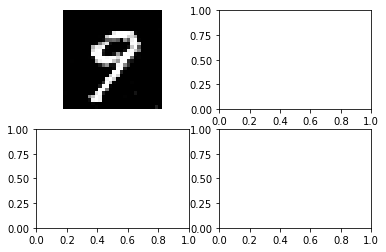

In [43]:
gen_imgs = gan.generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs + 0.5) * 1 #0,1にrescale
fig, axs = plt.subplots(2, 2)
axs[0,0].axis('off')
axs[0,0] = axs[0,0].imshow(gen_imgs[0, :,:,0], cmap='gray') # shape = (1, 100)だとエラーが出る。

In [44]:
from PIL import Image

In [45]:
r, c = 1, 1
noise = np.random.normal(0, 1, (r * c, 100)) # 平均0、標準偏差1の正規分布, shape = (r * c, 100)
noise.shape #generatorに(100,1)を入れたらエラー
gen_imgs = gan.generator.predict(noise) # -1,1の値を持つ。
gen_imgs = (0.5 * gen_imgs + 0.5) * 255 #0,255にrescale
gen_imgs = gen_imgs[0].astype('uint8')

In [46]:
img_RGB = np.concatenate((gen_imgs, gen_imgs, gen_imgs), axis=2) # 3色にしないとエラーがでる。
img = Image.fromarray(img_RGB)
img

In [47]:
zero_array = np.zeros((28,28,3), dtype='uint8') # Broadcastで28,28,3にしてしまう。
zero_array.dtype
gen_imgs = zero_array + gen_imgs
img = Image.fromarray(gen_imgs)
img